Loading preprocessed ECG data...

Structure of first data item:
dict_keys(['participant', 'condition', 'data', 'filtered_data', 'derive_sq_data'])

Participant: sub-01, Condition: empty_bright
Number of peaks detected: 352
Recording duration: 4.98 minutes
Average BPM: 70.64


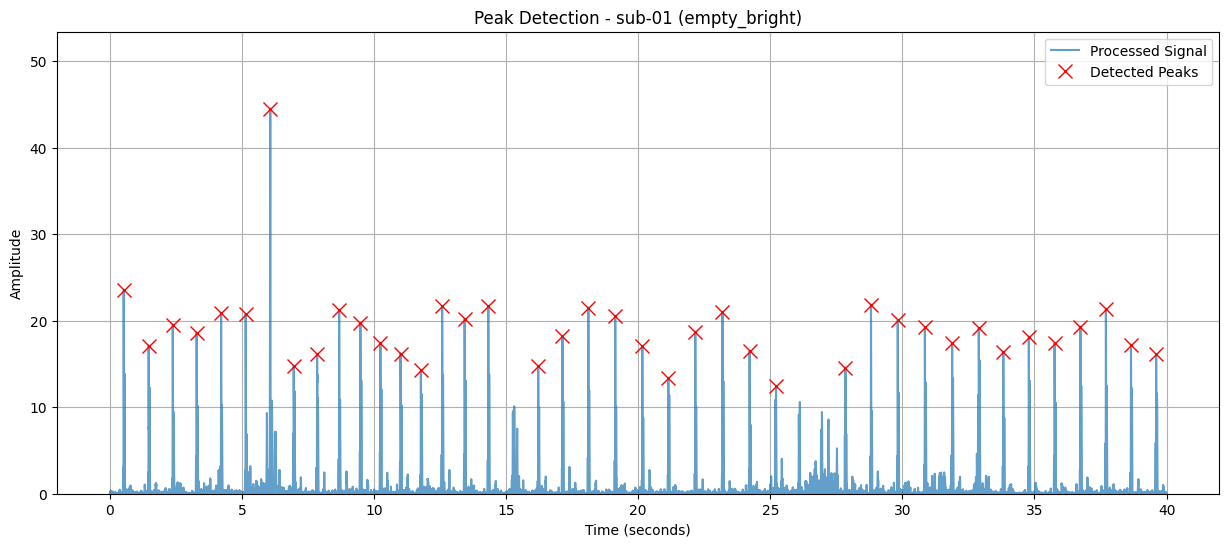


Participant: sub-01, Condition: empty_dark
Number of peaks detected: 283
Recording duration: 3.98 minutes
Average BPM: 71.05


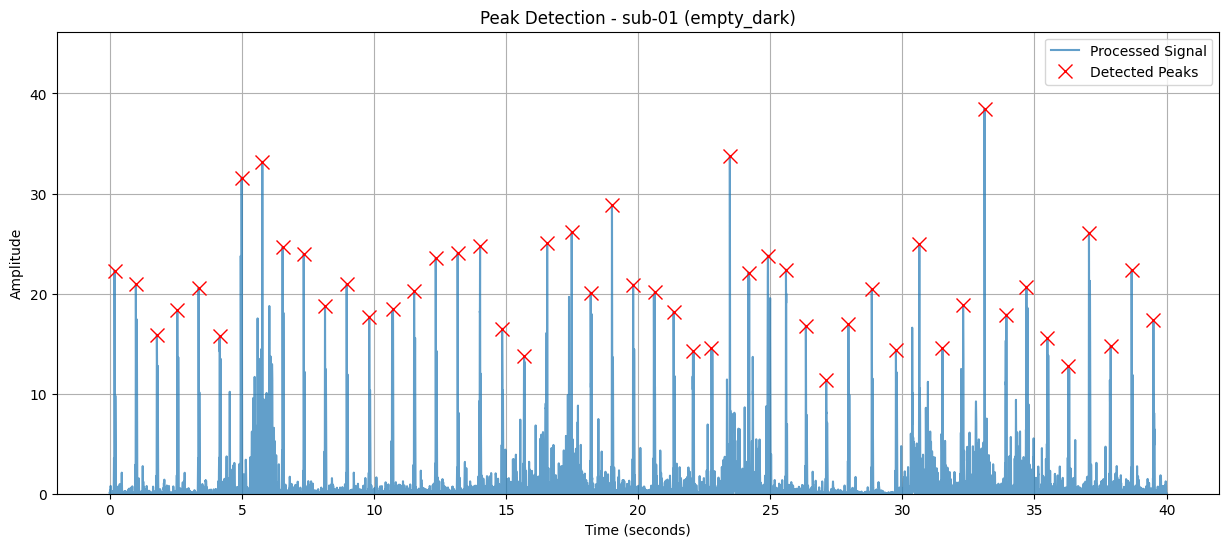


Participant: sub-01, Condition: full_bright
Number of peaks detected: 409
Recording duration: 5.98 minutes
Average BPM: 68.36


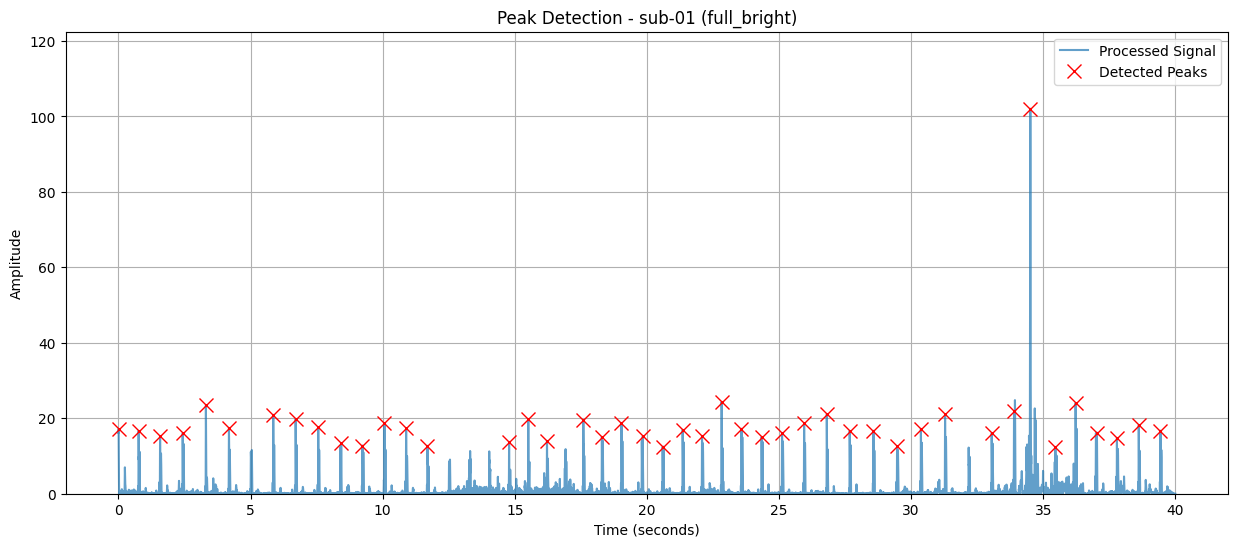


Participant: sub-01, Condition: full_dark
Number of peaks detected: 203
Recording duration: 3.00 minutes
Average BPM: 67.67


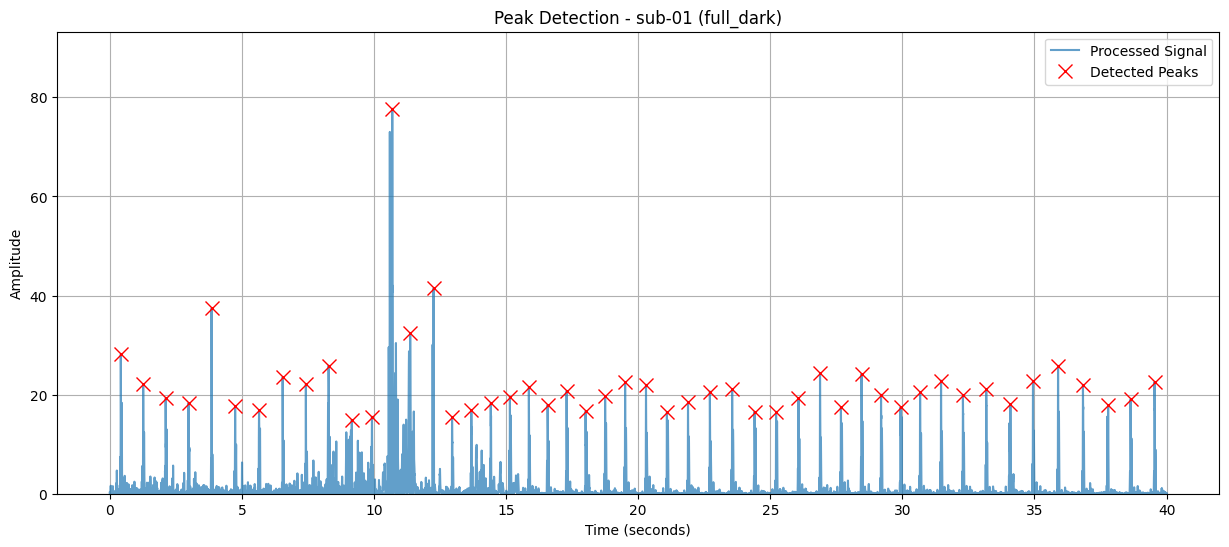


Participant: sub-02, Condition: empty_bright
Number of peaks detected: 370
Recording duration: 4.98 minutes
Average BPM: 74.25


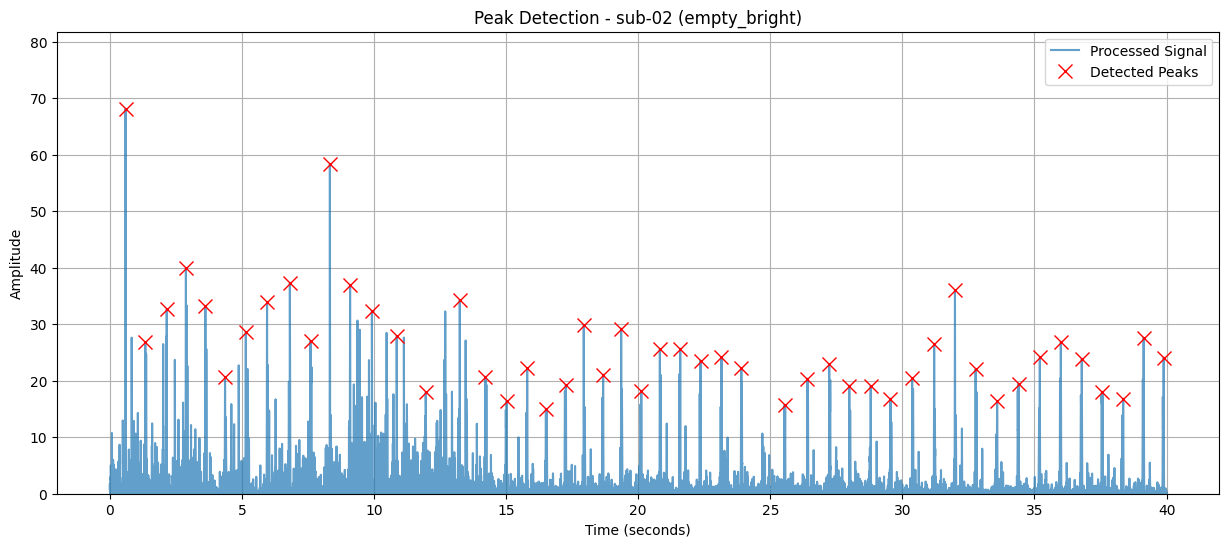


Participant: sub-02, Condition: empty_dark
Number of peaks detected: 297
Recording duration: 3.98 minutes
Average BPM: 74.56


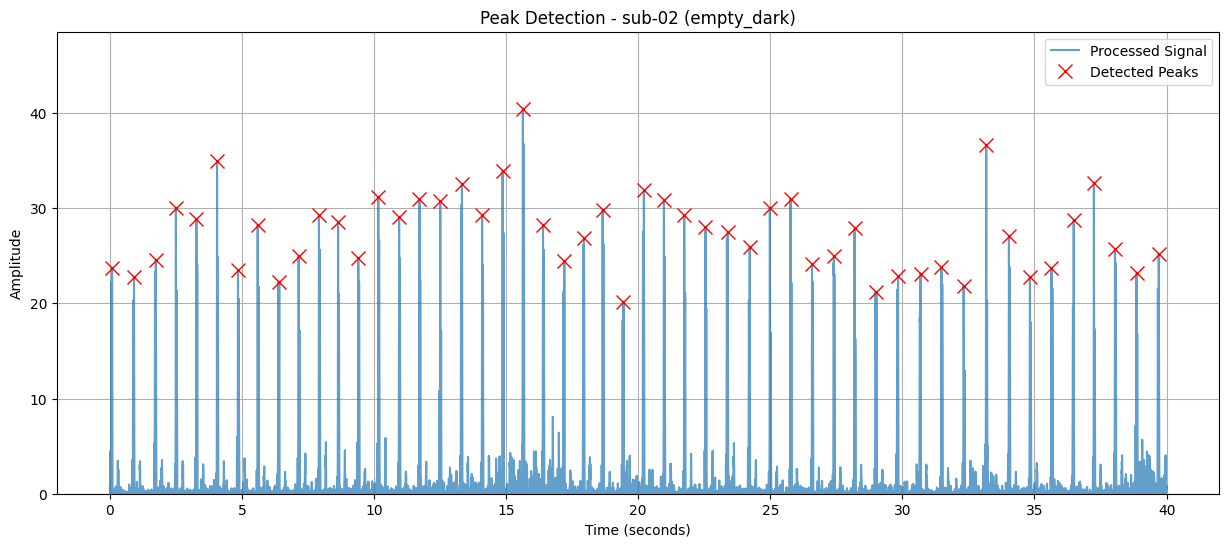


Participant: sub-02, Condition: full_bright
Number of peaks detected: 442
Recording duration: 5.98 minutes
Average BPM: 73.87


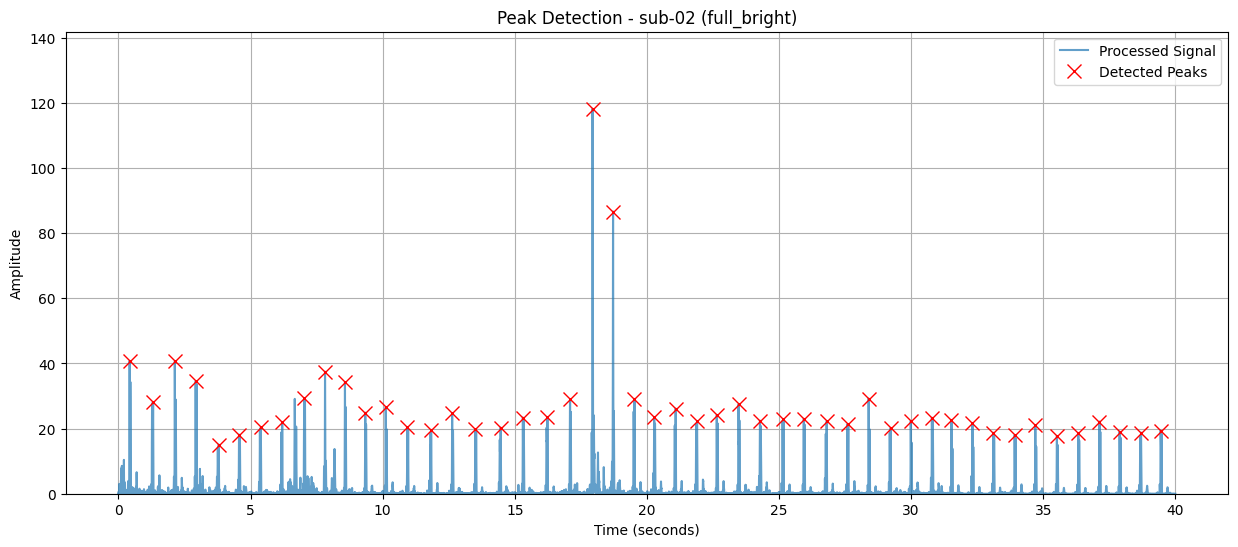


Participant: sub-02, Condition: full_dark
Number of peaks detected: 220
Recording duration: 3.00 minutes
Average BPM: 73.33


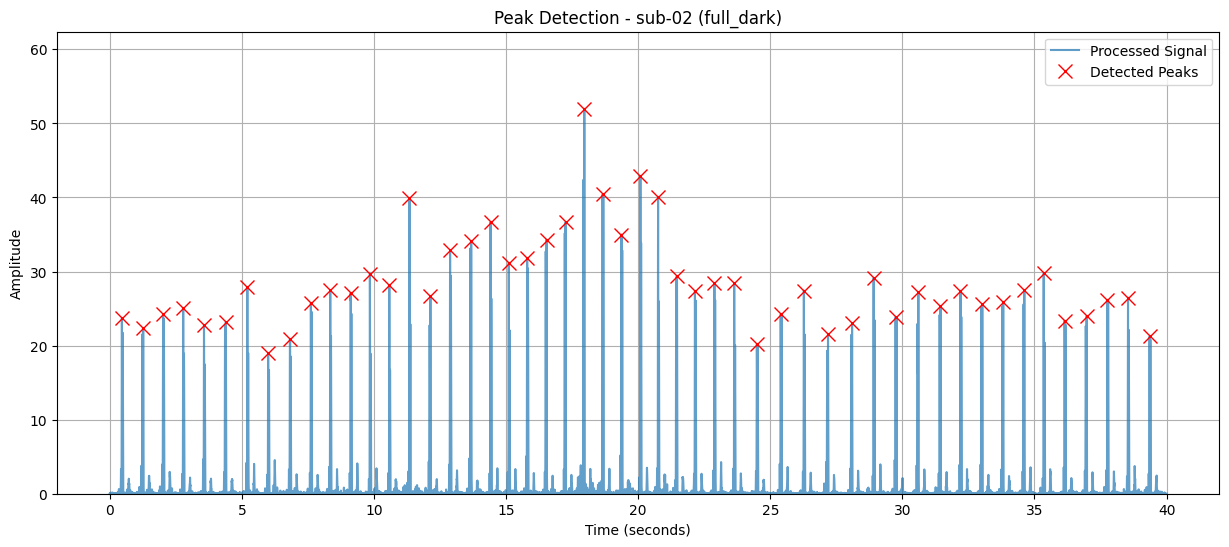


Saving processed data with BPM values...
Processing complete!


In [1]:
import pandas as pd
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt
import pickle

# File paths
derivative_folder = '/Users/firefly/Desktop/Team_Messung/data/preprocessed-data'
output_filename = f"{derivative_folder}/preprocessed_ecg.pkl"

# Load the preprocessed data
print("Loading preprocessed ECG data...")
with open(output_filename, 'rb') as f:
    loaded_data = pickle.load(f)

# Display structure of first item
print("\nStructure of first data item:")
print(loaded_data[0].keys())

# Process each dataset
for participant_data in loaded_data:
    # Extract metadata
    condition_name = participant_data["condition"]
    participant_name = participant_data["participant"]
    
    # Get squared derivative data
    derive_sq_data = participant_data["derive_sq_data"].flatten()
    
    # Calculate adaptive threshold
    signal_mean = np.mean(derive_sq_data)
    signal_std = np.std(derive_sq_data)
    indiv_threshold = signal_mean + 3 * signal_std
    
    # Set minimum distance between peaks
    sampling_frequency = 1000  # Hz
    min_ecg_interval = 0.6    # seconds (corresponds to 100 BPM)
    indiv_distance = int(min_ecg_interval * sampling_frequency)
    
    # Find peaks
    peaks, _ = signal.find_peaks(derive_sq_data, 
                                height=indiv_threshold,
                                distance=indiv_distance)
    
    # Calculate BPM
    peak_times = peaks / sampling_frequency  # Convert to seconds
    num_minutes = (derive_sq_data.shape[0] / sampling_frequency) / 60
    bpm = len(peaks) / num_minutes
    
    print(f"\nParticipant: {participant_name}, Condition: {condition_name}")
    print(f"Number of peaks detected: {len(peaks)}")
    print(f"Recording duration: {num_minutes:.2f} minutes")
    print(f"Average BPM: {bpm:.2f}")
    
    # Plot first 40 seconds
    first_segment_samples = sampling_frequency * 40
    time_axis = np.arange(first_segment_samples) / sampling_frequency
    
    plt.figure(figsize=(15, 6))
    
    # Plot the squared derivative data
    plt.plot(time_axis, 
            derive_sq_data[:first_segment_samples], 
            label="Processed Signal",
            alpha=0.7)
    
    # Plot detected peaks
    first_segment_peaks = peaks[peaks < first_segment_samples]
    plt.plot(first_segment_peaks / sampling_frequency,
            derive_sq_data[first_segment_peaks],
            "rx",
            label="Detected Peaks",
            markersize=10)
    
    plt.title(f"Peak Detection - {participant_name} ({condition_name})")
    plt.xlabel("Time (seconds)")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.grid(True)
    
    # Automatically set y-axis limits to focus on the peaks
    max_amplitude = np.max(derive_sq_data[:first_segment_samples])
    plt.ylim(0, max_amplitude * 1.2)  # Add 20% margin above maximum
    
    plt.show()
    
    # Store BPM in the participant's data
    participant_data["bpm"] = bpm

# Save updated data with BPM values
print("\nSaving processed data with BPM values...")
with open(output_filename, 'wb') as f:
    pickle.dump(loaded_data, f)

